In [73]:
import tensorflow 
import cv2
import numpy as np
import os
from random import shuffle
from tqdm import tqdm
from matplotlib.image import imread

from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping

import sys
import matplotlib.pyplot as plt
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout, BatchNormalization, Input, Activation, SeparableConv2D, GlobalAveragePooling2D, GlobalMaxPooling2D

from tensorflow.keras.optimizers import SGD
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from IPython.display import display
from PIL import Image

from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
import random 
from tensorflow.keras import models
from tensorflow.keras import backend as K

import pandas as pd

from tensorflow.keras.applications import VGG16, Xception, ResNet50, ResNet101, InceptionResNetV2, DenseNet201

import scipy as sp
import h5py

from tensorflow.keras.models import Model
from tensorflow.keras import layers


In [2]:
gpus = tensorflow.config.experimental.list_physical_devices('GPU')
tensorflow.config.experimental.set_memory_growth(gpus[0], True)

In [3]:
IMAGE_WIDTH=128
IMAGE_HEIGHT=128

In [87]:
#Write the local Data and Model Path
DATA_PATH = 'C:\\Users\\pacol\\Desktop\\GIT\\COVID19\\data\\'
MODEL_PATH = 'C:\\Users\\pacol\\Desktop\\GIT\\COVID19\\data\\Models\\LAST\\'

In [4]:
def data_generator(batch_size):
    train_datagen = ImageDataGenerator(rescale = 1./255)
    val_datagen = ImageDataGenerator(rescale = 1./255)
    test_datagen = ImageDataGenerator(rescale = 1./255)

    BATCH_SIZE = batch_size
    IMAGE_WIDTH=128
    IMAGE_HEIGHT=128
    IMAGE_SIZE=(IMAGE_WIDTH, IMAGE_HEIGHT)

    train_dir = DATA_PATH + 'Sorted Data\\train'
    train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size = IMAGE_SIZE,
        batch_size = BATCH_SIZE,
        shuffle = True,
        class_mode = 'categorical'
    )

    test_dir = DATA_PATH + 'Sorted Data\\test'
    test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size = IMAGE_SIZE,
        batch_size = BATCH_SIZE,
        shuffle = True,
        class_mode = 'categorical'
    )

    val_dir = DATA_PATH + 'Sorted Data\\val'
    val_generator = val_datagen.flow_from_directory(
        val_dir,
        target_size = IMAGE_SIZE,
        batch_size = BATCH_SIZE,
        shuffle = True,
        class_mode = 'categorical'
    )
    return train_generator, test_generator, val_generator


In [5]:
#We need to create the Xception architecture model from scratch in order to access to the convolutional layers inside it

def Xception(include_top=False,
             weights=None,
             input_tensor=None,
             input_shape=(128,128,3),
             pooling='avg',
             classes=3,
             **kwargs):

    img_input = Input(shape=input_shape)
    
    x = Conv2D(32, (3, 3), strides=(2, 2), use_bias=False, name='block1_conv1')(img_input)
    x = BatchNormalization(name='block1_conv1_bn')(x)
    x = Activation('relu', name='block1_conv1_act')(x)
    x = Conv2D(64, (3, 3), use_bias=False, name='block1_conv2')(x)
    x = BatchNormalization(name='block1_conv2_bn')(x)
    x = Activation('relu', name='block1_conv2_act')(x)

    residual = Conv2D(128, (1, 1), strides=(2, 2),
                      padding='same', use_bias=False)(x)
    residual = BatchNormalization()(residual)

    x = SeparableConv2D(128, (3, 3), padding='same', use_bias=False, name='block2_sepconv1')(x)
    x = BatchNormalization(name='block2_sepconv1_bn')(x)
    x = Activation('relu', name='block2_sepconv2_act')(x)
    x = SeparableConv2D(128, (3, 3), padding='same', use_bias=False, name='block2_sepconv2')(x)
    x = BatchNormalization(name='block2_sepconv2_bn')(x)

    x = MaxPooling2D((3, 3), strides=(2, 2), padding='same', name='block2_pool')(x)
    x = layers.add([x, residual])

    residual = Conv2D(256, (1, 1), strides=(2, 2),
                      padding='same', use_bias=False)(x)
    residual = BatchNormalization()(residual)

    x = Activation('relu', name='block3_sepconv1_act')(x)
    x = SeparableConv2D(256, (3, 3), padding='same', use_bias=False, name='block3_sepconv1')(x)
    x = BatchNormalization(name='block3_sepconv1_bn')(x)
    x = Activation('relu', name='block3_sepconv2_act')(x)
    x = SeparableConv2D(256, (3, 3), padding='same', use_bias=False, name='block3_sepconv2')(x)
    x = BatchNormalization(name='block3_sepconv2_bn')(x)

    x = MaxPooling2D((3, 3), strides=(2, 2), padding='same', name='block3_pool')(x)
    x = layers.add([x, residual])

    residual = Conv2D(728, (1, 1), strides=(2, 2),
                      padding='same', use_bias=False)(x)
    residual = BatchNormalization()(residual)

    x = Activation('relu', name='block4_sepconv1_act')(x)
    x = SeparableConv2D(728, (3, 3), padding='same', use_bias=False, name='block4_sepconv1')(x)
    x = BatchNormalization(name='block4_sepconv1_bn')(x)
    x = Activation('relu', name='block4_sepconv2_act')(x)
    x = SeparableConv2D(728, (3, 3), padding='same', use_bias=False, name='block4_sepconv2')(x)
    x = BatchNormalization(name='block4_sepconv2_bn')(x)

    x = MaxPooling2D((3, 3), strides=(2, 2), padding='same', name='block4_pool')(x)
    x = layers.add([x, residual])

    for i in range(8):
        residual = x
        prefix = 'block' + str(i + 5)

        x = Activation('relu', name=prefix + '_sepconv1_act')(x)
        x = SeparableConv2D(728, (3, 3), padding='same', use_bias=False, name=prefix + '_sepconv1')(x)
        x = BatchNormalization(name=prefix + '_sepconv1_bn')(x)
        x = Activation('relu', name=prefix + '_sepconv2_act')(x)
        x = SeparableConv2D(728, (3, 3), padding='same', use_bias=False, name=prefix + '_sepconv2')(x)
        x = BatchNormalization(name=prefix + '_sepconv2_bn')(x)
        x = Activation('relu', name=prefix + '_sepconv3_act')(x)
        x = SeparableConv2D(728, (3, 3), padding='same', use_bias=False, name=prefix + '_sepconv3')(x)
        x = BatchNormalization(name=prefix + '_sepconv3_bn')(x)

        x = layers.add([x, residual])

    residual = Conv2D(1024, (1, 1), strides=(2, 2),
                      padding='same', use_bias=False)(x)
    residual = BatchNormalization()(residual)

    x = Activation('relu', name='block13_sepconv1_act')(x)
    x = SeparableConv2D(728, (3, 3), padding='same', use_bias=False, name='block13_sepconv1')(x)
    x = BatchNormalization(name='block13_sepconv1_bn')(x)
    x = Activation('relu', name='block13_sepconv2_act')(x)
    x = SeparableConv2D(1024, (3, 3), padding='same', use_bias=False, name='block13_sepconv2')(x)
    x = BatchNormalization(name='block13_sepconv2_bn')(x)

    x = MaxPooling2D((3, 3), strides=(2, 2), padding='same', name='block13_pool')(x)
    x = layers.add([x, residual])

    x = SeparableConv2D(1536, (3, 3), padding='same', use_bias=False, name='block14_sepconv1')(x)
    x = BatchNormalization(name='block14_sepconv1_bn')(x)
    x = Activation('relu', name='block14_sepconv1_act')(x)

    x = SeparableConv2D(2048, (3, 3), padding='same', use_bias=False, name='block14_sepconv2')(x)
    x = BatchNormalization(name='block14_sepconv2_bn')(x)
    x = Activation('relu', name='block14_sepconv2_act')(x)
    x = GlobalAveragePooling2D(name='avg_pool')(x)
    
    x = Flatten()(x) 
    x = Dense(512, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    x = Dense(3, activation='softmax')(x)
    
    inputs = img_input
    
    model = Model(inputs, x, name='xception')
    
    return model


In [6]:
#Train the model in order to obtain its weights 

opt=tensorflow.keras.optimizers.SGD(learning_rate=0.003, momentum=0.9)
epochs = 20
batch_size = 32
loss = 'categorical_crossentropy'

train_generator, test_generator, val_generator = data_generator(batch_size)

model = Xception()
model.compile(optimizer=opt, loss=loss, metrics=['accuracy'])
model.summary()

os.chdir(DATA_PATH + 'data\\Models\\LAST')

checkpoint = ModelCheckpoint('model_Xception_CAM_epochs_{}_optimizer_adam_batch_{}.h5'.format(epochs,batch_size), 
                             monitor='val_accuracy', 
                             verbose=1, 
                             save_best_only=True, 
                             save_weights_only=False, 
                             mode='auto', 
                             period=1)

callbacks_list = [checkpoint]

model.fit(train_generator,
            epochs=epochs,
            verbose=1,
            shuffle=True,
            steps_per_epoch = 2560 / batch_size,
            validation_data = val_generator,
            callbacks=callbacks_list)

    

Found 2560 images belonging to 3 classes.
Found 800 images belonging to 3 classes.
Found 640 images belonging to 3 classes.
Model: "xception"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 63, 63, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 63, 63, 32)   128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 63, 63, 32)   0           b

Train for 80.0 steps, validate for 20 steps
Epoch 1/20
79/80 [============================>.] - ETA: 0s - loss: 0.6749 - accuracy: 0.7765
Epoch 00001: val_accuracy improved from -inf to 0.33594, saving model to model_Xception_CAM_epochs_20_optimizer_adam_batch_32.h5
80/80 [==============================] - 40s 494ms/step - loss: 0.6712 - accuracy: 0.7777 - val_loss: 1.1308 - val_accuracy: 0.3359
Epoch 2/20
79/80 [============================>.] - ETA: 0s - loss: 0.3281 - accuracy: 0.8786
Epoch 00002: val_accuracy did not improve from 0.33594
80/80 [==============================] - 28s 348ms/step - loss: 0.3260 - accuracy: 0.8797 - val_loss: 1.2032 - val_accuracy: 0.3359
Epoch 3/20
79/80 [============================>.] - ETA: 0s - loss: 0.2066 - accuracy: 0.9296
Epoch 00003: val_accuracy did not improve from 0.33594
80/80 [==============================] - 28s 348ms/step - loss: 0.2065 - accuracy: 0.9297 - val_loss: 1.0971 - val_accuracy: 0.3359
Epoch 4/20
79/80 [=====================

# Class Activation Map

In [ ]:
#Load the model

model = load_model(MODEL_PATH + 'model_Xception_CAM_epochs_20_optimizer_adam_batch_32.h5')

In [18]:
model.summary()

Model: "xception"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 63, 63, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 63, 63, 32)   128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 63, 63, 32)   0           block1_conv1_bn[0][0]            
___________________________________________________________________________________________

COVID Image
Classification Probabilities:  [[1.0000000e+00 1.8354399e-08 1.0191221e-08]]
Model predict the image as: COVID


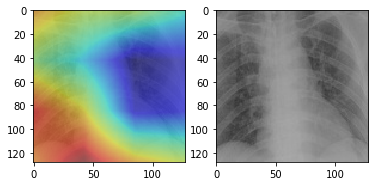

NORMAL Image
Classification Probabilities:  [[3.2466105e-09 1.0000000e+00 1.4247651e-09]]
Model predict the image as: NORMAL Image


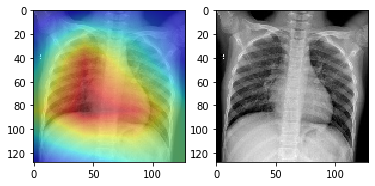

PNEUMONIA Image
Classification Probabilities:  [[1.2399538e-05 6.0825339e-05 9.9992681e-01]]
Model predict the image as: PNEUMONIA Image


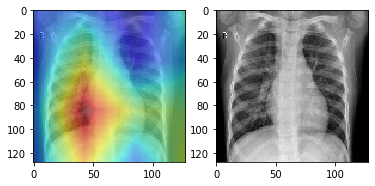

In [82]:
#This block generates 3 random CAMs, one for each class

activation_layer = model.get_layer('block14_sepconv2_act')

model_map = Model(inputs=model.input, outputs=activation_layer.output)

final_dense = model.get_layer('dense')
W = final_dense.get_weights()[0]

batch=np.random.randint(0,79)

X,Y=train_generator[batch]
j=0


for i in range(3):
    
    
    while np.argmax(label) != i:
        j=np.random.randint(0,31)
        img_res= X[j]
        img = np.expand_dims(X[j], axis=0)
        label = Y[j]
    
    if np.argmax(label) == 0:
        print('COVID Image')
        
    if np.argmax(label) == 1:
        print('NORMAL Image')
        
    if np.argmax(label) == 2:
        print('PNEUMONIA Image')
    
    fmaps = model_map.predict(img)[0]
    fmaps.shape

    probs = model.predict(img)
    print('Classification Probabilities: ', probs)

    pred = np.argmax(probs[0])
    
    if pred == 0:
        print('Model predict the image as: COVID')
        
    if pred == 1:
        print('Model predict the image as: NORMAL Image')
        
    if pred == 2:
        print('Model predict the image as: PNEUMONIA Image')

    w = W[:, pred]
    cam = fmaps.dot(w)
    cam = sp.ndimage.zoom(cam, (32, 32), order=1)

    plt.subplot(1,2,1)
    plt.imshow(img_res, alpha=0.8)
    plt.imshow(cam, cmap='jet', alpha=0.5)
    plt.subplot(1,2,2)
    plt.imshow(img_res)
    plt.show()

In [70]:
results = model.evaluate(test_generator)

25/25 [==============================] - 4s 168ms/step - loss: 0.1151 - accuracy: 0.9750


In [71]:
results

[0.11506904799549375, 0.975]